<a href="https://colab.research.google.com/github/aurotripathy/RL-Experiments/blob/main/gpt2_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tune GPT2 to generate positive reviews
Optimise GPT2 to produce positive IMDB movie reviews using a BERT sentiment classifier as a reward function.


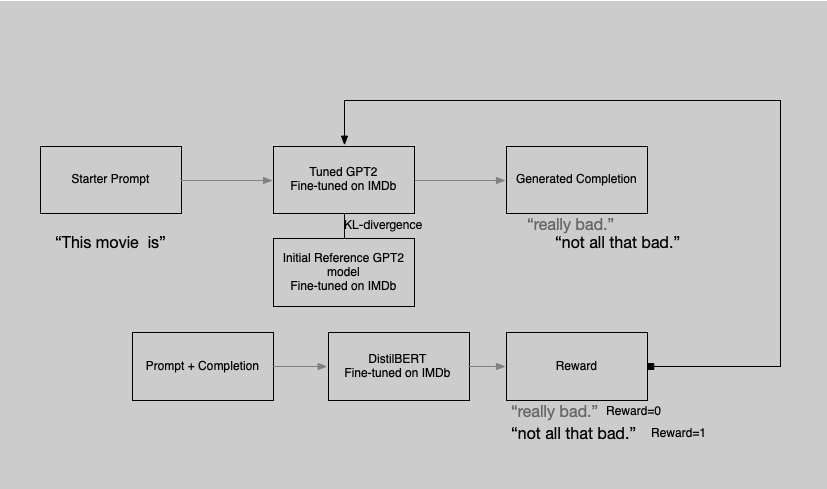

<div style="text-align: center">
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The IMDb tuned models (GPT2 and DistilBERT) are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


In this notebook we fine-tune GPT2 (small) to generate positive movie reviews based on the IMDB dataset. The model gets the start of a real review and is tasked to produce positive continuations. To reward positive continuations, we use a BERT classifier to analyse the sentiment of the produced sentences and use the classifier's outputs as rewards signals for PPO training.

## Setup experiment

### Import dependencies

In [ ]:
# This version uses an older TRL library
%pip install transformers wandb
%pip install trl==0.11.0

In [ ]:
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

### Configuration

In [ ]:
config = PPOConfig(
    learning_rate=1.41e-5,
    log_with="wandb",
)

sentiment_kwargs = {"top_k": None, "function_to_apply": None, "batch_size": 16}

In [ ]:
import wandb

wandb.init()

You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/main/examples/legacy/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://huggingface.co/papers/1909.08593). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

## Load data and models

### Load IMDB dataset and Tokenize
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 200 characters. Then we tokenize each text and cut it to random size with the `LengthSampler`.

In [ ]:
def build_dataset_and_tokenize(
    config,
    model_name="gpt2",  # Add model_name as an argument
    dataset_name="stanfordnlp/imdb",
    input_min_text_length=2,
    input_max_text_length=8,
):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)  # Use model_name argument
    tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)
    print(f"****input min text len: {input_min_text_length}, {input_max_text_length}")

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [ ]:
dataset = build_dataset_and_tokenize(config, model_name="gpt2")  # Pass model_name here


def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is to be optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [ ]:
model = AutoModelForCausalLMWithValueHead.from_pretrained("gpt2")
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token

### Initialize PPOTrainer
The `PPOTrainer` takes care of device placement and optimization later on:

In [ ]:
ppo_trainer = PPOTrainer(
    config, model, ref_model, tokenizer
)

### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset (`distilbert-imdb`).

In [ ]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug
sentiment_pipe = pipeline(
    "sentiment-analysis", model="lvwerra/distilbert-imdb", device=device
)

The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [ ]:
text = "this movie was really bad!!"
sentiment_pipe(text, **sentiment_kwargs)

In [ ]:
text = "this movie was really good!!"
sentiment_pipe(text, **sentiment_kwargs)

### Generation settings
For the response generation we just use sampling and make sure top-k and nucleus sampling are turned off as well as a minimal length.

In [ ]:
gen_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

## Optimize model

### Training loop

The training loop consists of the following main steps:
1. Get the query responses from the policy network (GPT-2)
2. Get sentiments for query/responses from BERT (the reward model)
3. Optimize policy with PPO using the (query, response, reward) triplet

**Training time**

This step takes **~2h** on a V100 GPU with the above specified settings.

On a A100/40GB, it takes ***~45min***

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=config.batch_size, collate_fn=collator)
ppo_trainer.dataloader = dataloader

In [ ]:
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)


generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}


for epoch, batch in enumerate(tqdm(ppo_trainer.dataloader)):
    # print(f"epoch:{epoch}, len batch:{len(batch)}")
    query_tensors = batch["input_ids"]
    if len(query_tensors) < 128:
        print(f"query_tensors length: {len(query_tensors)} probably the last batch...breaking")
        break
    # Move query_tensors to the correct device
    query_tensors = [query.to(device) for query in query_tensors]


    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        # query is already on the correct device
        query_response = ppo_trainer.generate(query, **generation_kwargs).squeeze()
        response_len = len(query_response) - len(query)
        response_tensors.append(query_response[-response_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sentiment_kwargs)
    positive_scores = [
        item["score"]
        for output in pipe_outputs
        for item in output
        if item["label"] == "POSITIVE"
    ]
    rewards = [torch.tensor(score) for score in positive_scores]
    # Move rewards to the correct device
    rewards = [reward.to(device) for reward in rewards]


    #### Run PPO step
    # print(f'running PPO step')
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

### Training progress
If you are tracking the training progress with Weights&Biases you should see a plot similar to the one below. Check out the interactive sample report on wandb.ai: [link](https://wandb.ai/furiosaai-nlp/trl/runs/n0qaygz2/workspace?nw=nwuseraurotripathy).

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2_tuning_progress.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Reward mean and distribution evolution during training. </p>
</div>

One can observe how the model starts to generate more positive outputs after a few optimisation steps.

> Note: Investigating the KL-divergence will probably show that at this point the model has not converged to the target KL-divergence, yet. To get there would require longer training or starting with a higher initial coefficient.

## Model inspection
Let's inspect some examples from the IMDB dataset. We can use `ref_model` to compare the tuned model `model` against the model before optimisation.

In [ ]:
#### get a batch from the dataset
bs = 16
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    query = torch.tensor(query_tensors[i]).to(device)

    gen_len = output_length_sampler()
    query_response = ref_model.generate(
        query.unsqueeze(0), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()
    response_len = len(query_response) - len(query)
    response_tensors_ref.append(query_response[-response_len:])

    query_response = model.generate(
        query.unsqueeze(0), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()
    response_len = len(query_response) - len(query)
    response_tensors.append(query_response[-response_len:])

#### decode responses
game_data["response (before)"] = [
    tokenizer.decode(response_tensors_ref[i]) for i in range(bs)
]
game_data["response (after)"] = [
    tokenizer.decode(response_tensors[i]) for i in range(bs)
]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
positive_scores = [
    item["score"]
    for output in pipe_outputs
    for item in output
    if item["label"] == "POSITIVE"
]
game_data["rewards (before)"] = positive_scores

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
positive_scores = [
    item["score"]
    for output in pipe_outputs
    for item in output
    if item["label"] == "POSITIVE"
]
game_data["rewards (after)"] = positive_scores

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

Looking at the reward mean/median of the generated sequences we observe a significant difference.

In [ ]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

## Save model
Finally, we save the model and push it to the Hugging Face for later usage.

In [ ]:
# model.save_pretrained("gpt2-imdb-pos-v2", push_to_hub=True)
# tokenizer.save_pretrained("gpt2-imdb-pos-v2", push_to_hub=True)